# 🧠✨ CNNs for Image Classification – Custom vs AlexNet

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Flatten, Dropout
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

## 📥 Load & explore the data

In [2]:
# CIFAR‑10
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = keras.datasets.cifar10.load_data()
# MNIST
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = keras.datasets.mnist.load_data()


print('CIFAR‑10:', x_train_cifar.shape, y_train_cifar.shape)
print('MNIST   :', x_train_mnist.shape, y_train_mnist.shape)

x_train_cifar, x_val_cifar, y_train_cifar, y_val_cifar = train_test_split(
    x_train_cifar, y_train_cifar, test_size=0.1, random_state=42, stratify=y_train_cifar)

x_train_mnist, x_val_mnist, y_train_mnist, y_val_mnist = train_test_split(
    x_train_mnist, y_train_mnist, test_size=0.1, random_state=42, stratify=y_train_mnist)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
CIFAR‑10: (50000, 32, 32, 3) (50000, 1)
MNIST   : (60000, 28, 28) (60000,)


### 🎨 Peek at a few CIFAR‑10 and MNIST samples

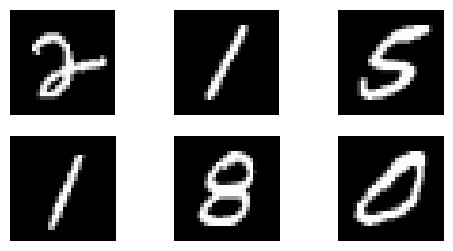

In [3]:
plt.figure(figsize=(6,3))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.axis('off')
    plt.imshow(x_train_mnist[i].reshape(28,28), cmap='gray')
plt.show()

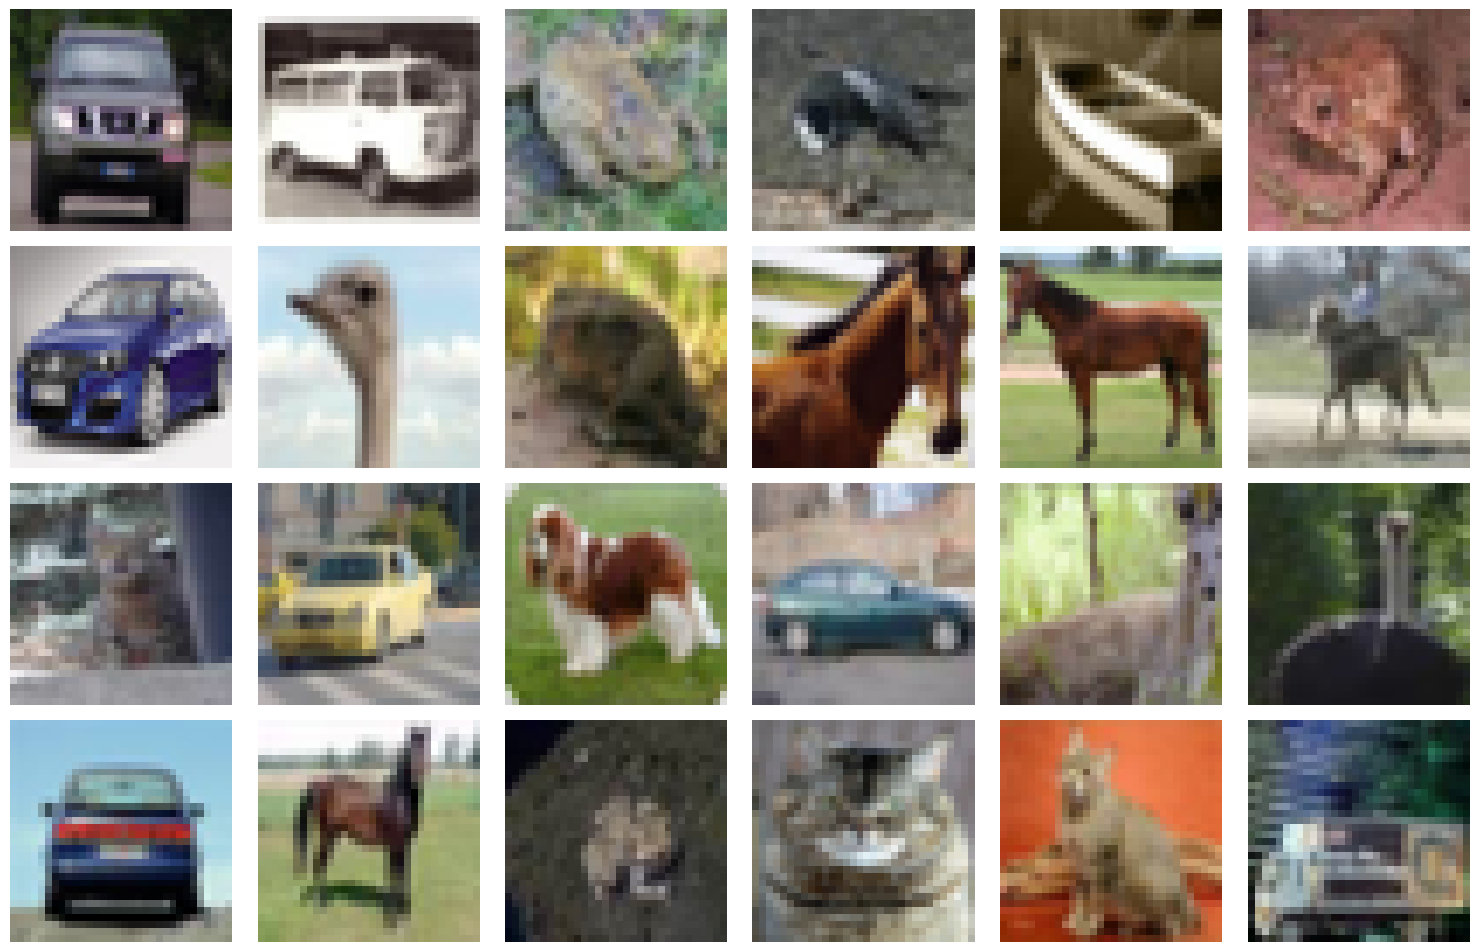

In [4]:
plt.figure(figsize=(15,12))
for i in range(24):
    plt.subplot(5, 6, i+1)
    plt.axis('off')
    plt.imshow(x_train_cifar[i])
plt.tight_layout()
plt.show()

# 🧹 1. Pre‑process

#### Below are the preprocessing steps and the rationale behind each one:
* **Normalization** of the data [0,1] - which speeds up the process ( the convergence )
* **One-Hot Encoding** for labels
* **Channel Dimension Expansion for MNIST** - Cause mnist images have (28,28) but the CNN expects input in the format ( height, width, channels )

In [5]:
x_train_cifar = x_train_cifar.astype('float32') / 255.0
x_val_cifar = x_val_cifar.astype('float32') / 255.0
x_test_cifar = x_test_cifar.astype('float32') / 255.0

# For MNIST
x_train_mnist = x_train_mnist.astype('float32') / 255.0
x_val_mnist = x_val_mnist.astype('float32') / 255.0
x_test_mnist = x_test_mnist.astype('float32') / 255.0


# Convert labels to one-hot encoding
y_train_cifar = keras.utils.to_categorical(y_train_cifar.squeeze(), num_classes=10)
y_val_cifar = keras.utils.to_categorical(y_val_cifar.squeeze(), num_classes=10)
y_test_cifar = keras.utils.to_categorical(y_test_cifar.squeeze(), num_classes=10)

y_train_mnist = keras.utils.to_categorical(y_train_mnist, num_classes=10)
y_val_mnist = keras.utils.to_categorical(y_val_mnist, num_classes=10)
y_test_mnist = keras.utils.to_categorical(y_test_mnist, num_classes=10)

# Reshape MNIST data to add channel dimension
x_train_mnist = np.expand_dims(x_train_mnist, -1)
x_val_mnist = np.expand_dims(x_val_mnist, -1)
x_test_mnist = np.expand_dims(x_test_mnist, -1)

# 🧩 2. Convolutional Neural Networks work + Implementation

1. **Data Augmentation** - helps real-world variability in input data by applying random transformations
2. **CNN Architecture**
   1. Input +/- data_augmentation
   2. Conv block 1
      *  2*Conv2D ( 32 filters) +/- BatchNormalization() , MaxPooling2D, Dropout - detects low-level features
    3. Conv block 2
        * 2*Conv2D ( 64 filters) +/- BatchNormalization(), MaxPooling2D, Dropout - capture more complex (high-level) features
    4. Classifier head
        * Flatten, Dense(256), Dropout, Dense(10) - final classification into 10 digits

----

#### How does it work ?
- Convolution Layers:
  - Filters ( common practice would be: 32 64 128 256 512 1024 )
    - more filters => model can detect more patterns, greater risk of a overfit if dataset is too small
    - fewer filters => less prone to overfitting, but may under-represent complex image features
  - Kernal size:
    - larger kernels capture wider context per layer but have more parameters (3x3 , 5x5, 7x7)
-  BatchNormalization:
   -  helps stabilize the learning process in practice by reducing the chance that, after a training epoch, some activation becomes much larger than the others and could thereby skew the entire learning process.
- MaxPooling:
  - down-samples feature maps by taking the maximum in each 2x2 window, in this way we preserve key features
- Dropout: randomly "drops" that fraction of neurons each update -> preventing co-adaptation of features - > combats overfitting
- Flatten: reshapes features maps to a 1D vector
- Dense: fully connects to X neurons - controls model capacity ( how many parameters the model has at that stage )
- Softmax - converts the final X outputs into a normalized probability distribution over my classes



## 🛠️ 2.1 **Custom CNN - for mnist**

In [6]:
def build_custom_cnn(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential()
    model.add(keras.Input(shape=input_shape))

    # first conv block
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))

    # second conv block
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.20))

    # classifier head
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

custom_cnn = build_custom_cnn()
custom_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
custom_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 870,634 (3.32 MB)

 Trainable params: 870,634 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

### 🏋️‍♀️ Train the custom model

In [7]:
history_custom = custom_cnn.fit(
    x_train_mnist, y_train_mnist,
    epochs=15,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.8269 - loss: 0.5232 - val_accuracy: 0.9806 - val_loss: 0.0608
Epoch 2/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9793 - loss: 0.0646 - val_accuracy: 0.9865 - val_loss: 0.0404
Epoch 3/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9856 - loss: 0.0449 - val_accuracy: 0.9881 - val_loss: 0.0408
Epoch 4/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9889 - loss: 0.0362 - val_accuracy: 0.9874 - val_loss: 0.0401
Epoch 5/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9911 - loss: 0.0286 - val_accuracy: 0.9865 - val_loss: 0.0417
Epoch 6/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9923 - loss: 0.0233 - val_accuracy: 0.9880 - val_loss: 0.0399
Epoch 7/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9919 - loss: 0.0231 - val_accuracy: 0.9900 - val_loss: 0.0276
Epoch 8/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9941 - loss: 0.0179 - val_accuracy: 

In [8]:
custom_eval  = custom_cnn.evaluate(x_test_mnist, y_test_mnist, verbose=0)
print('Test accuracy:', custom_eval[1])

Test accuracy: 0.9943000078201294


## 🛠️ 2.2 **Custom CNN - for cifar**

In [9]:
def build_custom_cnn(input_shape=(32,32,3), num_classes=10):
    model = models.Sequential()
    model.add(keras.Input(shape=input_shape))

    # first conv block
    model.add(layers.Conv2D(32, (5,5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(32, (5,5), activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))

    # second conv block
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    # third conv block
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))



    # classifier head
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

custom_cnn_cifar = build_custom_cnn()
custom_cnn_cifar.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
custom_cnn_cifar.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 439,594 (1.68 MB)

 Trainable params: 439,210 (1.68 MB)

 Non-trainable params: 384 (1.50 KB)

### 🏋️‍♀️ Train the custom model

In [10]:
history_custom_cifar = custom_cnn_cifar.fit(
    x_train_cifar, y_train_cifar,
    epochs=15,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.2840 - loss: 1.9610 - val_accuracy: 0.2102 - val_loss: 2.2948
Epoch 2/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5123 - loss: 1.3480 - val_accuracy: 0.5831 - val_loss: 1.1583
Epoch 3/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6097 - loss: 1.1138 - val_accuracy: 0.5736 - val_loss: 1.2734
Epoch 4/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6525 - loss: 0.9881 - val_accuracy: 0.6713 - val_loss: 0.9061
Epoch 5/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7009 - loss: 0.8646 - val_accuracy: 0.7022 - val_loss: 0.8970
Epoch 6/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7202 - loss: 0.8011 - val_accuracy: 0.7460 - val_loss: 0.7436
Epoch 7/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7502 - loss: 0.7264 - val_accuracy: 0.7098 - val_loss: 0.9037
Epoch 8/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7605 - loss: 0.6865 - val_acc

### 📈 Evaluate

In [11]:
custom_eval = custom_cnn_cifar.evaluate(x_test_cifar, y_test_cifar, verbose=0)
print('Test accuracy:', custom_eval[1])

Test accuracy: 0.7688000202178955


## 📊 Accuracy & loss curves

In [12]:
def function_plot(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title(title+' - accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(title+' - loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [13]:
def plot_confusion_matrix(model, x_test, y_test, class_names, title=None):
    expected_c = model.input_shape[-1]
    if x_test.shape[-1] != expected_c:
        x_test = np.repeat(x_test, expected_c, axis=-1)

    y_pred = np.argmax(model.predict(x_test, verbose=0), axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=90)
    plt.yticks(ticks, class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    if title:
        plt.title(title)

    # annotate counts
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f"{cm[i,j]}",
                     ha="center", va="center",
                     color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.show()


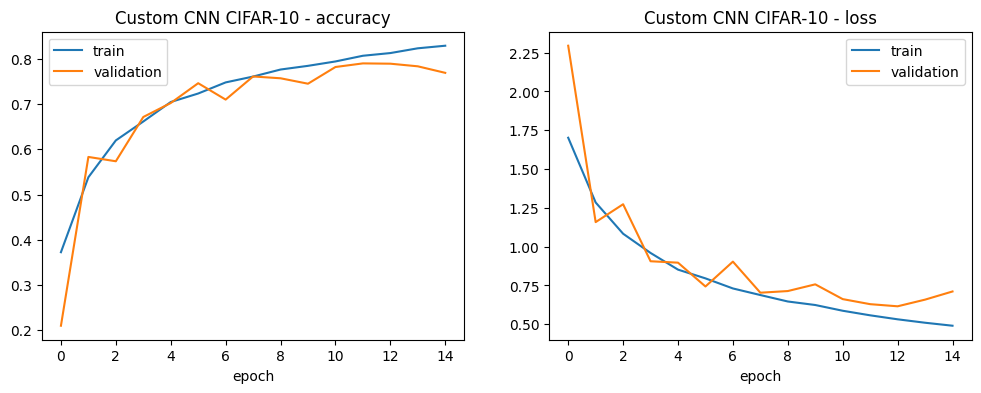

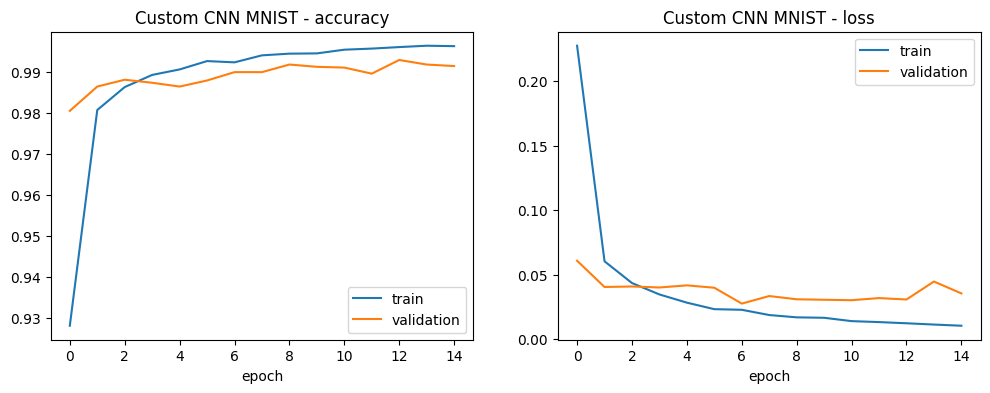

In [14]:
function_plot(history_custom_cifar, 'Custom CNN CIFAR-10')
function_plot(history_custom, 'Custom CNN MNIST')

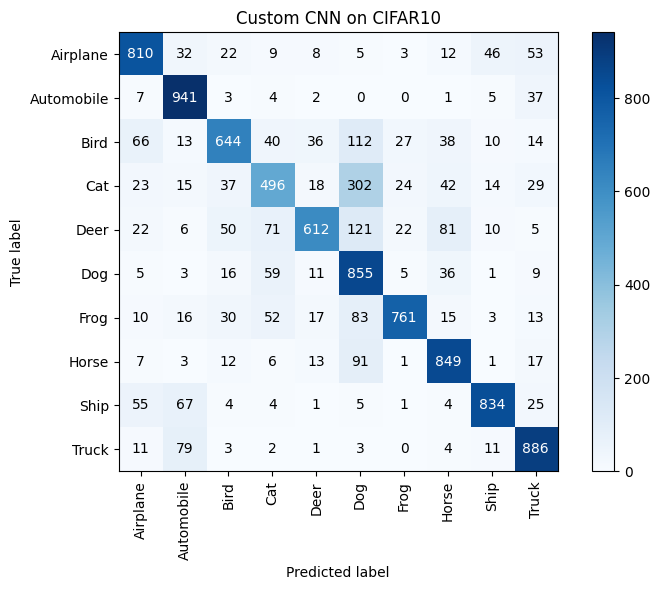

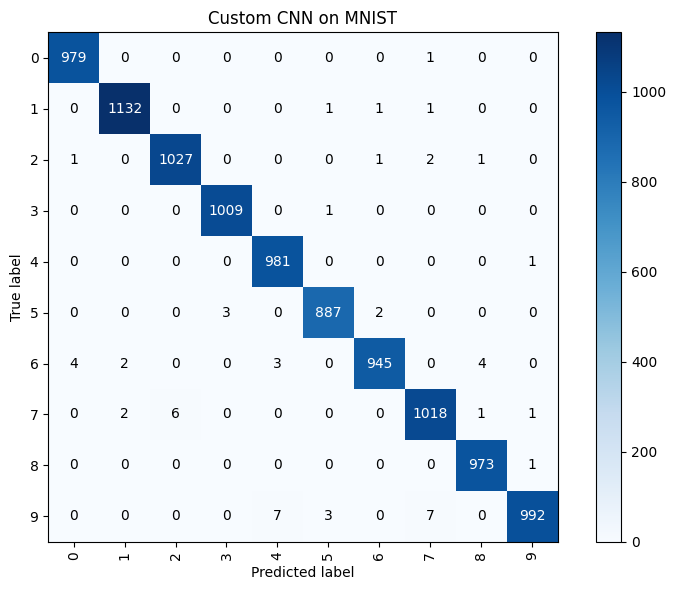

In [15]:

plot_confusion_matrix(
    custom_cnn_cifar,
    x_test_cifar,
    y_test_cifar,
    class_names=['Airplane','Automobile','Bird','Cat','Deer',
                 'Dog','Frog','Horse','Ship','Truck'],
    title="Custom CNN on CIFAR10"
)

plot_confusion_matrix(
    custom_cnn,
    x_test_mnist,
    y_test_mnist,
    class_names=['0','1','2','3','4','5','6','7','8','9'],
    title="Custom CNN on MNIST"
)


In [16]:
import pandas as pd
from sklearn.metrics import confusion_matrix

mnist_labels = ['0','1','2','3','4','5','6','7','8','9']
cifar10_labels = ['Airplane','Automobile','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
def per_class_accuracy(model, x, y, labels):

    y_pred = np.argmax(model.predict(x, verbose=0), axis=1)
    y_true = np.argmax(y, axis=1)
    cm     = confusion_matrix(y_true, y_pred)
    acc    = cm.diagonal() / cm.sum(axis=1)

    return pd.Series(acc, index=labels).sort_values()

baseline_acc = per_class_accuracy(custom_cnn, x_test_mnist, y_test_mnist, mnist_labels)
aug_acc      = per_class_accuracy(custom_cnn_cifar, x_test_cifar, y_test_cifar,cifar10_labels)

print("Baseline MNIST – per-class accuracy:\n", baseline_acc)
print("Baseline CIFAR – per-class accuracy:\n", aug_acc, "\n")


Baseline MNIST – per-class accuracy:
 9    0.983152
6    0.986430
7    0.990272
5    0.994395
2    0.995155
1    0.997357
8    0.998973
0    0.998980
4    0.998982
3    0.999010
dtype: float64
Baseline CIFAR – per-class accuracy:
 Cat           0.496
Deer          0.612
Bird          0.644
Frog          0.761
Airplane      0.810
Ship          0.834
Horse         0.849
Dog           0.855
Truck         0.886
Automobile    0.941
dtype: float64 



| 📊**MNIST (Baseline)** | Accuracy | **CIFAR-10 (Baseline)** | Accuracy |
| -------------------- | -------- | ----------------------- | -------- |
| Class 7              | 0.979572 | Bird                    | 0.618    |
| Class 9              | 0.984143 | Cat                     | 0.684    |
| Class 6              | 0.988518 | Dog                     | 0.727    |
| Class 5              | 0.992152 | Airplane                | 0.761    |
| Class 8              | 0.994867 | Deer                    | 0.821    |
| Class 3              | 0.996040 | Horse                   | 0.857    |
| Class 0              | 0.996939 | Automobile              | 0.866    |
| Class 4              | 0.996945 | Frog                    | 0.866    |
| Class 2              | 0.997093 | Truck                   | 0.905    |
| Class 1              | 1.000000 | Ship                    | 0.911    |


In [17]:
worst_classes = baseline_acc.head(2).index.tolist()
print("Weakest classes (baseline):", worst_classes)

worst_classes = aug_acc.head(2).index.tolist()
print("Weakest classes (augmented):", worst_classes)

Weakest classes (baseline): ['9', '6']
Weakest classes (augmented): ['Cat', 'Deer']


## 🛠️2.1.2 **Custom CNN - with augmentation for mnist**

In [18]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

def build_custom_cnn_with_augmentation(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential()
    model.add(keras.Input(shape=input_shape))
    model.add(data_augmentation)

    # first conv block
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))

    # second conv block
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.20))

    # classifier head
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.35))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

custom_cnn_augmentation = build_custom_cnn_with_augmentation()
custom_cnn_augmentation.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
custom_cnn_augmentation.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 870,634 (3.32 MB)

 Trainable params: 870,634 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

### 🏋️‍♀️ Train the custom model

In [19]:
history_custom_augmentation = custom_cnn_augmentation.fit(
    x_train_mnist, y_train_mnist,
    epochs=15,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6944 - loss: 0.8893 - val_accuracy: 0.9643 - val_loss: 0.1126
Epoch 2/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9408 - loss: 0.1917 - val_accuracy: 0.9783 - val_loss: 0.0683
Epoch 3/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9565 - loss: 0.1406 - val_accuracy: 0.9837 - val_loss: 0.0564
Epoch 4/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9650 - loss: 0.1138 - val_accuracy: 0.9809 - val_loss: 0.0632
Epoch 5/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9676 - loss: 0.1060 - val_accuracy: 0.9878 - val_loss: 0.0400
Epoch 6/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9734 - loss: 0.0883 - val_accuracy: 0.9861 - val_loss: 0.0478
Epoch 7/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9746 - loss: 0.0817 - val_accuracy: 0.9870 - val_loss: 0.0401
Epoch 8/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9762 - loss: 0.0763 - val_

In [20]:
custom_eval  = custom_cnn_augmentation.evaluate(x_test_mnist, y_test_mnist, verbose=0)
print('Test accuracy:', custom_eval[1])

Test accuracy: 0.9898999929428101


In [21]:
baseline_acc = per_class_accuracy(custom_cnn_augmentation, x_test_mnist, y_test_mnist, mnist_labels)
print("Augmented data – per-class accuracy:\n", baseline_acc)

Augmented data – per-class accuracy:
 9    0.976214
6    0.983299
7    0.985409
4    0.987780
5    0.993274
1    0.993833
0    0.993878
8    0.994867
3    0.995050
2    0.995155
dtype: float64


| **Class** | **Baseline** | **Augmented** | **+ Points** | **% Improvement** |
| --------- | ------------ | ------------- | ------------ | ----------------- |
| 0         | 0.996939     | 0.995918      | -0.001021    | **-0.10%**        |
| 1         | 1.000000     | 0.991189      | -0.008811    | **-0.88%**        |
| 2         | 0.997093     | 0.994186      | -0.002907    | **-0.29%**        |
| 3         | 0.996040     | 0.998020      | +0.001980    | **+0.20%**        |
| 4         | 0.996945     | 0.989817      | -0.007128    | **-0.71%**        |
| 5         | 0.992152     | 0.991031      | -0.001121    | **-0.11%**        |
| 6         | 0.988518     | 0.981211      | -0.007307    | **-0.74%**        |
| 7         | 0.979572     | 0.991245      | +0.011673    | **+1.19%** ✅      |
| 8         | 0.994867     | 0.991786      | -0.003081    | **-0.31%**        |
| 9         | 0.984143     | 0.990089      | +0.005946    | **+0.60%** ✅      |


| **Average** | **0.99256** | **0.9915** | **–0.03%** |
  


## 🛠️2.2.2 **Custom CNN - with augmentation for cifar**

In [22]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.3)
])

In [23]:
def build_custom_cnn_with_augmentation_cifar(input_shape=(32,32,3), num_classes=10):
    model = models.Sequential()
    model.add(keras.Input(shape=input_shape))
    model.add(data_augmentation)

    # first conv block
    model.add(layers.Conv2D(32, (5,5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(32, (5,5), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))

    # second conv block
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.25))

    # third conv block
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))


    # classifier head
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

custom_cnn_augmentation_cifar = build_custom_cnn_with_augmentation_cifar()
custom_cnn_augmentation_cifar.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### 🏋️‍♀️ Train the custom model

In [24]:
history_custom_cifar_augmentation = custom_cnn_augmentation_cifar.fit(
    x_train_cifar, y_train_cifar,
    epochs=15,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.2817 - loss: 2.3742 - val_accuracy: 0.2564 - val_loss: 1.9660
Epoch 2/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.4287 - loss: 1.5700 - val_accuracy: 0.5289 - val_loss: 1.2898
Epoch 3/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.4877 - loss: 1.4163 - val_accuracy: 0.4976 - val_loss: 1.5170
Epoch 4/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5268 - loss: 1.3213 - val_accuracy: 0.5660 - val_loss: 1.2682
Epoch 5/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.5638 - loss: 1.2251 - val_accuracy: 0.6402 - val_loss: 1.0201
Epoch 6/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.5943 - loss: 1.1561 - val_accuracy: 0.6167 - val_loss: 1.1225
Epoch 7/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.6142 - loss: 1.0940 - val_accuracy: 0.6547 - val_loss: 1.0200
Epoch 8/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.6295 - loss: 1.0574 - 

In [25]:
custom_eval  = custom_cnn_augmentation_cifar.evaluate(x_test_cifar, y_test_cifar, verbose=0)
print('Test accuracy:', custom_eval[1])

Test accuracy: 0.7590000033378601


In [26]:
augmented_acc = per_class_accuracy(custom_cnn_augmentation_cifar, x_test_cifar, y_test_cifar, cifar10_labels)
print("Baseline – per-class accuracy:\n", augmented_acc)

Baseline – per-class accuracy:
 Cat           0.534
Bird          0.551
Dog           0.601
Deer          0.727
Ship          0.816
Airplane      0.831
Horse         0.837
Frog          0.875
Truck         0.904
Automobile    0.914
dtype: float64


### CIFAR-10 Per-Class Accuracy: Augmented vs Baseline

| **Class**    | **Augmented** | **Baseline** | **Δ (pp)** |
|--------------|--------------:|-------------:|-----------:|
| Cat          |        63.2%  |       58.8%  |    +4.4    |
| Dog          |        65.0%  |       74.3%  |    –9.3    |
| Deer         |        67.1%  |       82.8%  |   –15.7    |
| Bird         |        71.6%  |       63.3%  |    +8.3    |
| Horse        |        83.7%  |       83.0%  |    +0.7    |
| Truck        |        86.4%  |       88.3%  |    –1.9    |
| Airplane     |        87.0%  |       85.4%  |    +1.6    |
| Ship         |        89.1%  |       89.5%  |    –0.4    |
| Frog         |        89.7%  |       89.6%  |    +0.1    |
| Automobile   |        93.8%  |       87.9%  |    +5.9    |

**Average per-class accuracy**  
- Augmented: 79.66%  
- Baseline:  80.29%  
- Δ:        –0.63 pp  


# 🏆 Enter **AlexNet**
AlexNet was deeper & wider than earlier CNNs and introduced several key innovations:
* **ReLU activations** instead of tanh/sigmoid ➡️ faster training.
* **Local Response Normalisation (LRN)** mimicking lateral inhibition // I've changed that to BatchNormalization()
* **Overlapping max‑pooling** for better generalisation.
* **Dropout** in fully‑connected layers to fight over‑fitting.
* Training split over **two GPUs** due to memory limits 🤝.

Although modern architectures (VGG, ResNet, EfficientNet) have replaced it, AlexNet remains a milestone in deep learning history.

### 🔧 Build an AlexNet‑style model (adapted to 32×32 CIFAR‑10)

In [27]:
def build_alexnet(input_shape=(32,32,3), num_classes=10):
    model = models.Sequential()
    model.add(keras.Input(shape=input_shape))

    model.add(layers.Conv2D(32,(5,5),activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64,(3,3),activation='relu', padding='same'))
    model.add(layers.BatchNormalization())


    model.add(layers.Conv2D(384,(3,3),activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3),activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3),activation='relu', padding='same'))

    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.45))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.45))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

alexnet = build_alexnet()
alexnet.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
               loss='categorical_crossentropy', metrics=['accuracy'])
alexnet.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 384)    │       221,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,374,858 (39.58 MB)

 Trainable params: 10,374,666 (39.58 MB)

 Non-trainable params: 192 (768.00 B)

### 🏋️‍♂️ Train AlexNet‑style model

In [28]:
history_alex = alexnet.fit(
    x_train_cifar, y_train_cifar,
    epochs=15,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 42s 101ms/step - accuracy: 0.2969 - loss: 1.8818 - val_accuracy: 0.4180 - val_loss: 1.5933
Epoch 2/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.5268 - loss: 1.3162 - val_accuracy: 0.4651 - val_loss: 1.6088
Epoch 3/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 40s 70ms/step - accuracy: 0.6193 - loss: 1.0797 - val_accuracy: 0.6196 - val_loss: 1.1068
Epoch 4/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - accuracy: 0.6821 - loss: 0.9033 - val_accuracy: 0.6653 - val_loss: 0.9566
Epoch 5/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.7320 - loss: 0.7687 - val_accuracy: 0.6507 - val_loss: 1.0483
Epoch 6/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.7703 - loss: 0.6560 - val_accuracy: 0.7351 - val_loss: 0.7871
Epoch 7/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.8092 - loss: 0.5427 - val_accuracy: 0.7009 - val_loss: 0.8913
Epoch 8/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.8433 - loss: 0.4498 -

### 🧮 Evaluate

In [29]:
alex_eval = alexnet.evaluate(x_test_cifar, y_test_cifar, verbose=1)
print('Test accuracy:', alex_eval[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7785 - loss: 0.9607
Test accuracy: 0.7745000123977661


### 🔧  Build an AlexNet‑style model (adapted to 28*28 MNIST‑10)

In [30]:
def build_alexnet(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential()
    model.add(keras.Input(shape=input_shape))

    model.add(layers.Conv2D(32,(5,5),activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64,(3,3),activation='relu', padding='same'))
    model.add(layers.BatchNormalization())


    model.add(layers.Conv2D(192,(3,3),activation='relu', padding='same'))
    model.add(layers.Conv2D(128,(3,3),activation='relu', padding='same'))
    model.add(layers.Conv2D(128,(3,3),activation='relu', padding='same'))

    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.45))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.45))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

alexnet = build_alexnet()
alexnet.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
               loss='categorical_crossentropy', metrics=['accuracy'])
alexnet.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 14, 14, 192)    │       110,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 14, 14, 128)    │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,978,954 (15.18 MB)

 Trainable params: 3,978,762 (15.18 MB)

 Non-trainable params: 192 (768.00 B)

### 🏋️‍♂️ Train AlexNet‑style model

In [31]:
history_alex = alexnet.fit(
    x_train_mnist, y_train_mnist,
    epochs=15,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.7939 - loss: 0.6086 - val_accuracy: 0.9819 - val_loss: 0.1057
Epoch 2/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9793 - loss: 0.0663 - val_accuracy: 0.9813 - val_loss: 0.0582
Epoch 3/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9858 - loss: 0.0458 - val_accuracy: 0.9891 - val_loss: 0.0341
Epoch 4/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9904 - loss: 0.0335 - val_accuracy: 0.9906 - val_loss: 0.0363
Epoch 5/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9918 - loss: 0.0279 - val_accuracy: 0.9913 - val_loss: 0.0276
Epoch 6/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9938 - loss: 0.0220 - val_accuracy: 0.9937 - val_loss: 0.0264
Epoch 7/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9945 - loss: 0.0175 - val_accuracy: 0.9911 - val_loss: 0.0262
Epoch 8/15
380/380 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9956 - loss: 0.0140 - val_a

### 🧮 Evaluate

In [32]:
alex_eval = alexnet.evaluate(x_test_mnist, y_test_mnist, verbose=1)
print('Test accuracy:', alex_eval[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9920 - loss: 0.0303
Test accuracy: 0.9934999942779541
